# Building Damage Forecasts

This notebook reproduces the main results and plots of the manuscript "..." by Thomas Röösli, Christof Appenzeller and David N. Bresch, soon to be submitted to "Meteorological Applications".

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
from pathlib import Path
import pandas as pd
import pyproj
import fiona
import datetime as dt
from pandas import DataFrame
from cartopy.io import shapereader
from cartopy import crs as ccrs

from climada.hazard import StormEurope
from climada.hazard.storm_europe import generate_WS_forecast_hazard
from climada.entity import LitPop, Exposures, ImpactFunc, ImpactFuncSet
from climada.entity.impact_funcs.storm_europe import IFStormEurope

from climada.engine.forecast import Forecast
from climada.util.coordinates import read_raster_sample as u_read_raster_sample
from climada.util.plot import make_map as u_make_map

In [2]:
hazard_file = 'WS_C2E_run2018010100_event20180103.hdf5'
exposure_file = 'CHE_LitPop.hdf5'
HbW_exposure_file = 'CHE_HbW_exposure.hdf5'
HbW_cantons_file = 'cantons.shp'
adm1_shape_file = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_1_states_provinces')
event_damages_file = 'event_damages.csv'
exp_luxembourg_file = 'LUX_LitPop.hdf5'

## weather forecast

In [3]:
#load the wind gust forecast from the COSMO-2E forecast run started at January 1 2018 for January 3 2018
haz_burglind = StormEurope()
haz_burglind.read_hdf5(hazard_file)

2021-03-31 09:55:43,975 - climada.hazard.base - INFO - Reading WS_C2E_run2018010100_event20180103.hdf5


C:\Users\ThomasRoosli\anaconda3\envs\climada_env_20210315\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## exposure Figure 1

2021-03-31 09:55:44,057 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-31 09:55:44,057 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-31 09:55:44,057 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-31 09:55:44,057 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-31 09:55:44,057 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-31 09:55:44,088 - climada.entity.exposures.base - INFO - Reading CHE_LitPop.hdf5


C:\shortpaths\GitHub\climada_python\climada\entity\exposures\base.py:219: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  self.gdf.crs = self.meta['crs']


2021-03-31 09:55:44,226 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-31 09:55:44,226 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-31 09:55:44,226 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-31 09:55:44,242 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-31 09:55:44,242 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326


C:\shortpaths\GitHub\climada_python\climada\entity\exposures\base.py:616: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  self.gdf.crs = val


2021-03-31 09:55:44,628 - climada.util.coordinates - INFO - Raster from resolution 0.008333333333325754 to 0.008333333333325754.


C:\Users\ThomasRoosli\anaconda3\envs\climada_env_20210315\lib\site-packages\cartopy\mpl\feature_artist.py:213: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  c = matplotlib.collections.PathCollection(paths,


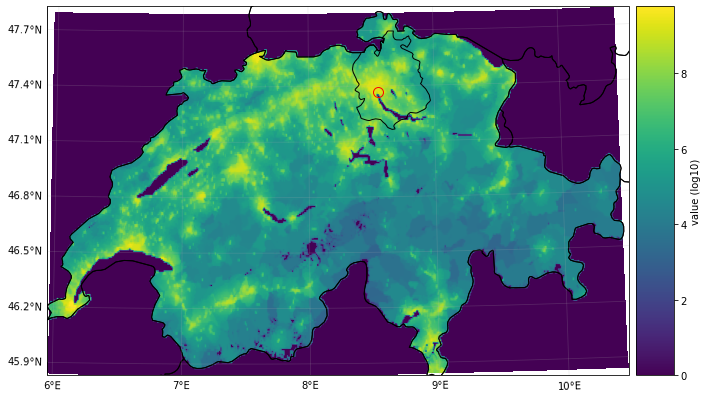

In [4]:
# a LitPop exposure for Switzerland is created.
# For this to work, a file containing the gridded population needs
# to be downloaded from https://sedac.ciesin.columbia.edu/data/collection/gpw-v4/sets/browse
# and saved in the respective folder. More information in the error message of the function LitPop.set_country()
if Path(exposure_file).exists():
    exp_litpop = Exposures()
    exp_litpop.read_hdf5(exposure_file)
else:
    exp_litpop = LitPop()
    exp_litpop.set_country('Switzerland')
    exp_litpop.assign_centroids(haz_burglind)
    exp_litpop.write_hdf5(exposure_file)
#plot exposure  
fig,axis = u_make_map(proj=ccrs.epsg(21781))
axis = exp_litpop.plot_raster(axis=axis)
#add shape of canton of Zurich
shapes = shapereader.Reader(adm1_shape_file)
zurich_shapes = [geom  for geom, rec in zip(shapes.geometries(),shapes.records()) if rec.attributes['adm1_code']=='CHE-176']
axis.add_geometries(zurich_shapes, crs=ccrs.PlateCarree(), facecolor='',
                    edgecolor='black')
#add circle for the city of Zurich
axis.plot(8.5500000, 47.3666700, 'ro', markersize=10,
                          transform=ccrs.PlateCarree(), markerfacecolor='None')   

## vulnerability Figure 2

Text(0, 0.5, 'mean impact ratio [%]')

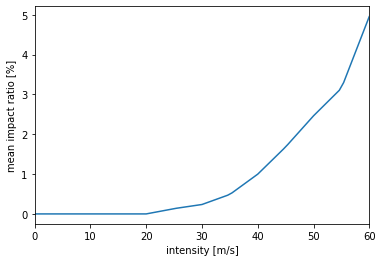

In [5]:
impfun = IFStormEurope()
impfun.set_welker()

impfun_set = ImpactFuncSet()
impfun_set.append(impfun)


plt.plot(impfun.intensity,
         impfun.mdd*100)
plt.xlim([0, 60])
plt.xlabel('intensity [m/s]')
plt.ylabel('mean impact ratio [%]')

## exposure and vulnerability for hazard based warnings (HbW)

In [6]:
## exposure for hazard based warnings
if Path(HbW_exposure_file).exists():
    HbW_exp = Exposures()
    HbW_exp.read_hdf5(HbW_exposure_file)
else:
    #add elevation to the hazard
    #needs a file from Swisstopo Switzerland
    #download from https://opendata.swiss/en/dataset/das-digitale-hohenmodell-der-schweiz-mit-einer-maschenweite-von-200-m
    #and adjust the path below to your downloaded file
    topo_path='D:\\Documents_DATA\\Swiss DEM\\DHM200.xyz'


    transformer = pyproj.Transformer.from_crs('epsg:4150', 'epsg:21781')
    x_ch, y_ch = transformer.transform(haz_burglind.centroids.lat,
                                       haz_burglind.centroids.lon)

    haz_burglind.centroids.set_elevation(topo_path=topo_path) # does not work but initiates zeros
    haz_burglind.centroids.elevation[~np.isinf(x_ch)] = u_read_raster_sample(
        topo_path,
        y_ch[~np.isinf(x_ch)],
        x_ch[~np.isinf(x_ch)]
        )
    # find out which hazard coord to consider
    CHE_borders = u_plot._get_borders(np.stack([exp_litpop.gdf.latitude.values,
                                                exp_litpop.gdf.longitude.values],
                                               axis=1)
                                     )
    centroid_selection = np.logical_and(np.logical_and(haz_burglind.centroids.lat >= CHE_borders[2],
                                                       haz_burglind.centroids.lat <= CHE_borders[3]),
                                        np.logical_and(haz_burglind.centroids.lon >= CHE_borders[0],
                                                       haz_burglind.centroids.lon <= CHE_borders[1])
                                       )
    # Fill DataFrame with values for a "neutral" exposure (value = 1)
    exp_df = DataFrame()
    exp_df['value'] = np.ones_like(haz_burglind.centroids.lat[centroid_selection]) # provide value
    exp_df['latitude'] = haz_burglind.centroids.lat[centroid_selection]
    exp_df['longitude'] = haz_burglind.centroids.lon[centroid_selection]
    exp_df['elevation'] = haz_burglind.centroids.elevation[centroid_selection]
    exp_df['if_WS'] = np.ones_like(haz_burglind.centroids.lat[centroid_selection], int)
    exp_df['if_WS'][exp_df['elevation']>1600] = 2

    # Generate Exposures
    HbW_exp = Exposures(exp_df)
    HbW_exp.check()
    HbW_exp.value_unit = 'warn_level'
    HbW_exp.assign_centroids(haz_burglind)
    HbW_exp.write_hdf5(HbW_exposure_file)

2021-03-31 09:56:01,905 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-31 09:56:01,905 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-31 09:56:01,905 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-31 09:56:01,905 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-31 09:56:01,905 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-31 09:56:01,937 - climada.entity.exposures.base - INFO - Reading CHE_HbW_exposure.hdf5
2021-03-31 09:56:01,952 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-31 09:56:01,952 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-31 09:56:01,952 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-31 09:56:01,952 - climada.entity.exposures.base - INFO - value_unit set to defaul

C:\shortpaths\GitHub\climada_python\climada\entity\exposures\base.py:219: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  self.gdf.crs = self.meta['crs']


2021-03-31 09:56:01,990 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-31 09:56:01,990 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


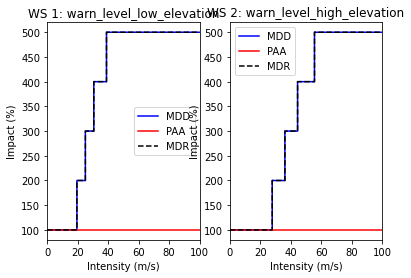

In [7]:
## impact functions for hazard based warnings
imp_fun_low = ImpactFunc() 
imp_fun_low.haz_type = 'WS'
imp_fun_low.id = 1
imp_fun_low.name = 'warn_level_low_elevation'
imp_fun_low.intensity_unit = 'm/s'
imp_fun_low.intensity = np.array([0.0, 19.439, 
                                  19.44, 24.999, 
                                  25.0, 30.549, 
                                  30.55, 38.879, 
                                  38.88, 100.0])
imp_fun_low.mdd = np.array([1.0, 1.0, 
                            2.0, 2.0, 
                            3.0, 3.0, 
                            4.0, 4.0, 
                            5.0, 5.0])
imp_fun_low.paa = np.ones_like(imp_fun_low.mdd)
imp_fun_low.check()

imp_fun_high = ImpactFunc() 
imp_fun_high.haz_type = 'WS'
imp_fun_high.id = 2
imp_fun_high.name = 'warn_level_high_elevation'
imp_fun_high.intensity_unit = 'm/s'
imp_fun_high.intensity = np.array([0.0, 27.776, 
                                  27.777, 36.110, 
                                  36.111, 44.443, 
                                  44.444, 55.554, 
                                  55.555, 100.0])
imp_fun_high.mdd = np.array([1.0, 1.0, 
                            2.0, 2.0, 
                            3.0, 3.0, 
                            4.0, 4.0, 
                            5.0, 5.0])
imp_fun_high.paa = np.ones_like(imp_fun_high.mdd)
imp_fun_high.check()

# fill ImpactFuncSet
Hbw_impf_set = ImpactFuncSet()
Hbw_impf_set.append(imp_fun_low)
Hbw_impf_set.append(imp_fun_high)
# plots can be modified using matplotlib as follows:
axes = Hbw_impf_set.plot()

## Burglind/Eleanor HbW  Figure 4b)

In [8]:
HbW_forecast = Forecast({dt.datetime(2018,1,1):haz_burglind},
                        HbW_exp,
                        Hbw_impf_set,
                        haz_model = 'C2E',
                        exposure_name='Switzerland'
                       )
HbW_forecast.calc()

2021-03-31 09:56:02,275 - climada.engine.impact - INFO - Exposures matching centroids found in centr_WS
2021-03-31 09:56:02,280 - climada.engine.impact - INFO - Calculating damage for 15124 assets (>0) and 21 events.


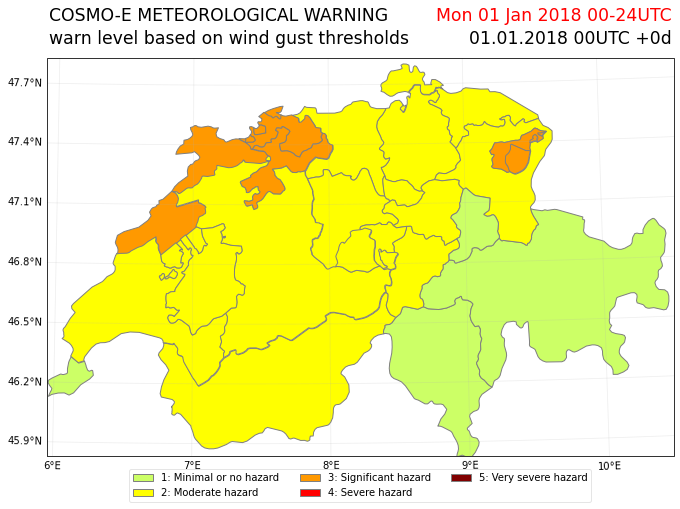

In [9]:
# use admin1 levels as warning regions as shape file for warning regions used by MeteoSwiss are not openly available
if not Path(HbW_cantons_file).exists():
    with fiona.open(adm1_shape_file, 'r') as source:
        with fiona.open(
                HbW_cantons_file, 'w',
                **source.meta) as sink:

            for f in source:
                if f['properties']['adm0_a3'] == 'CHE':
                    sink.write(f)
HbW_forecast.plot_warn_map(HbW_cantons_file,
                           decision_level = 'exposure_point',
                           probability_aggregation=0.5,
                           area_aggregation=0.5,
                           title="COSMO-E METEOROLOGICAL WARNING",
                           explain_text="warn level based on wind gust thresholds",
                           save_fig=False,
                           close_fig=False,
                           proj=ccrs.epsg(2056))
#plt.gca().set_extent((5.70, 10.49, 45.7, 47.81), crs=ccrs.PlateCarree())

## Burglind/Eleanor impact forecast Figure 4c)

In [10]:
burglind_forecast = Forecast({dt.datetime(2018,1,1):haz_burglind},
                             exp_litpop,
                             impfun_set,
                             haz_model = 'C2E',
                             exposure_name='Switzerland'
                            )
burglind_forecast.calc()

2021-03-31 09:56:03,398 - climada.engine.impact - INFO - Exposures matching centroids found in centr_WS
2021-03-31 09:56:03,405 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 21 events.
2021-03-31 09:56:03,406 - climada.engine.impact - INFO - Missing exposures impact functions for hazard if_WS. Using impact functions in if_.


array([[<cartopy.mpl.geoaxes.GeoAxesSubplot object at 0x000001E05DE395B0>]],
      dtype=object)

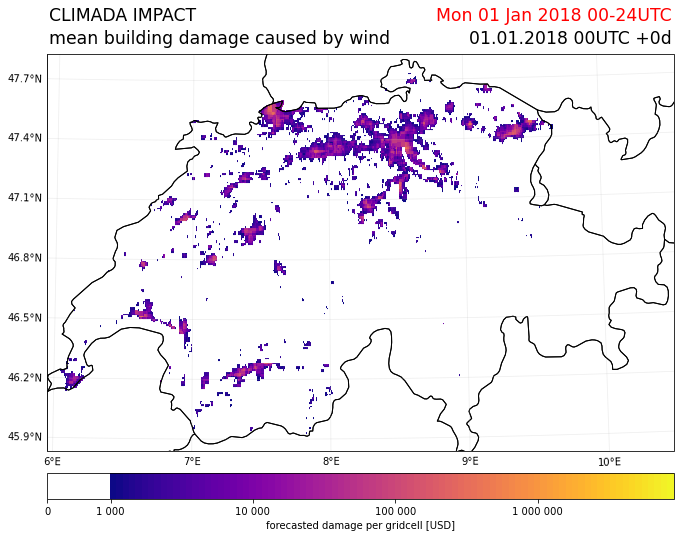

In [11]:
burglind_forecast.plot_imp_map(save_fig=False,close_fig=False,proj=ccrs.epsg(2056))

## Histogram of the forecasted building damages Figure 5

2021-03-31 09:56:06,042 - climada.util.value_representation - WARNING - Warning: The numbers are larger than 1000000000000
2021-03-31 09:56:06,042 - climada.util.value_representation - WARNING - Warning: The numbers are larger than 1000000000000
2021-03-31 09:56:06,042 - climada.util.value_representation - WARNING - Warning: The numbers are larger than 1000000000000


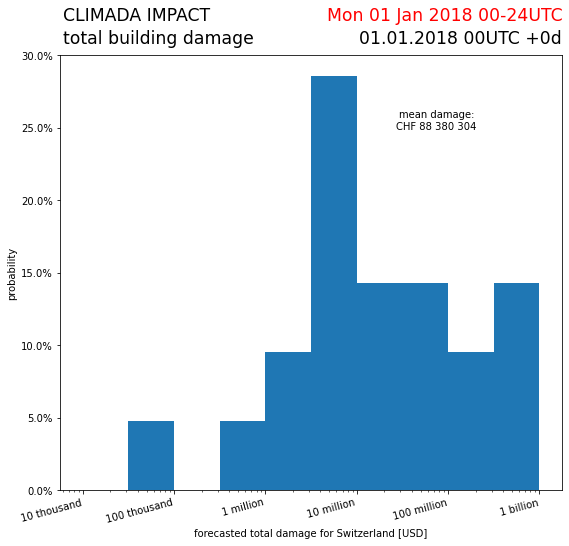

In [12]:
burglind_forecast.plot_hist(save_fig=False,close_fig=False)

## temporal forecast assessment Figure 6

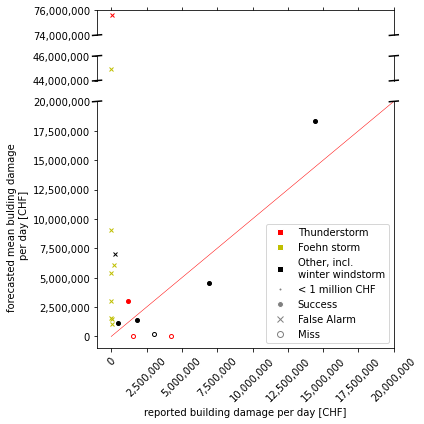

In [13]:
event_damages = pd.read_csv(event_damages_file)
event_damages['Event date'] = pd.to_datetime(event_damages['Event date'],format='%d/%m/%Y')
event_damages['Impact forecast'] = event_damages['Impact forecast'] * 1000000
event_damages['Reported damages'] = event_damages['Reported damages'] * 1000000

list_foehn_events = event_damages['Event date'][event_damages['Category']=='Foehn storm']
#create figure and axis
fig, (ax3, ax2, ax1) = plt.subplots(3, 1, sharex=True,
                                    figsize=(6,6),
                                    gridspec_kw={'height_ratios': 
                                                 [1, 1, 10]}
                                        )
#plot the 1-1 line
ax1.plot([0,2*10**7],[0,2*10**7],'-r', linewidth=0.5)
#plot each event as one point marker color, shape and size is dependent on the event
for _, i in event_damages.iterrows():
    size_i = 4
    if i['Category']=='Thunderstorms':
        color_i = 'r'
        mfc_i = 'red'
    elif i['Category']=='Foehn storm':
        color_i = 'y'
        mfc_i = 'yellow'
    else:
        color_i = 'k'
        mfc_i = 'black'
    if i['Impact forecast']>3*i['Reported damages']:
        marker_i = 'x'
    elif i['Impact forecast']<1/3*i['Reported damages']:
        marker_i = 'o'
        mfc_i = 'none'
    else:
        marker_i = 'o'
    for ax in [ax1, ax2, ax3]:
        ax.plot(i['Reported damages'],
                i['Impact forecast'],
                marker_i + color_i,
                mfc=mfc_i,
                markersize=size_i)
#adjust settings of plot
ax1.xaxis.set_major_formatter(FuncFormatter("{:,.0f}".format))
ax1.yaxis.set_major_formatter(FuncFormatter("{:,.0f}".format))        
ax2.xaxis.set_major_formatter(FuncFormatter("{:,.0f}".format))
ax2.yaxis.set_major_formatter(FuncFormatter("{:,.0f}".format)) 
ax3.xaxis.set_major_formatter(FuncFormatter("{:,.0f}".format))
ax3.yaxis.set_major_formatter(FuncFormatter("{:,.0f}".format)) 
plt.xlabel('reported building damage per day [CHF]')
plt.ylabel('forecasted mean bulding damage \nper day [CHF]')
ax1.set_xlim(-1000000,20000000)
ax1.set_ylim(-1000000,20000000)
ax2.set_ylim(44000000,46000000)
ax3.set_ylim(74000000,76000000)
plt.xticks(rotation=45)
ax3.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax3.xaxis.tick_top()
ax3.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.tick_params(axis='x',colors='w')
ax1.xaxis.tick_bottom()
plt.tight_layout()
#legend
legend_elements = [Line2D([0], [0], marker='s', color='w', mfc='r', label='Thunderstorm'),
                   Line2D([0], [0], marker='s', color='w', mfc='y', label='Foehn storm'),
                   Line2D([0], [0], marker='s', color='w', mfc='k', label='Other, incl. \nwinter windstorm'),
                   Line2D([0], [0], marker='.', color='w', mfc='gray', label='< 1 million CHF'),
                   Line2D([0], [0], marker='o', color='w', mfc='gray', label='Success'),
                   Line2D([0], [0], marker='x', color='w', mec='gray', label='False Alarm'),
                   Line2D([0], [0], marker='o', color='w', mec='gray', mfc='none', label='Miss'),
                   ]
ax1.legend(handles=legend_elements, loc='lower right')
# add diagonal cuts:
d = .015 
kwargs = dict(transform=ax3.transAxes, color='k', clip_on=False)
ax3.plot((-d, +d), (-d, +d), **kwargs)
ax3.plot((1 - d, 1 + d), (-d, +d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
d2 = d/10
kwargs.update(transform=ax1.transAxes)
ax1.plot((-d, +d), (1 - d2, 1 + d2), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d2, 1 + d2), **kwargs)

## Application to other countries
This methodology can be applied to any other European country using current weather forecast data of the german weather service. The forecast data is downloaded automatically from opendata.dwd.de. The default values for hazard, exposure and vulnerability can be easily changed, please consult the tutorial of the forecast class in the climada github repository.
The first execution needs to download and generate new files and might take awhile. 

In [14]:
#generate hazard
hazard_icon, haz_model_icon, run_datetime_icon, event_date_icon = generate_WS_forecast_hazard()

#generate vulnerability
# use impfun_set defined above

#generate exposure and save to file
if Path(exp_luxembourg_file).exists():
    exposure_lux = LitPop()
    exposure_lux.read_hdf5(exp_luxembourg_file)
else:
    exposure_lux = LitPop()
    exposure_lux.set_country('Luxembourg', reference_year=2020)
    exposure_lux.write_hdf5(exp_luxembourg_file)

#create and calculate Forecast
luxembourg_forecast = Forecast({run_datetime_icon: hazard_icon},
                               exposure_lux,
                               impfun_set,
                               haz_model=haz_model_icon,
                               exposure_name='Luxembourg',
                              )
luxembourg_forecast.calc()

2021-03-31 09:56:07,073 - climada.hazard.storm_europe - INFO - Generating IEE hazard.
2021-03-31 09:56:07,081 - climada.util.dwd_icon_loader - INFO - Downloading icon grib files of model icon-eu-eps for parameter vmax_10m with starting date 2021033100.
2021-03-31 09:56:07,181 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_001_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_001_vmax_10m.grib2.bz2


5.18kKB [00:00, 5.36kKB/s]                                                                                             


2021-03-31 09:56:08,684 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_002_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_002_vmax_10m.grib2.bz2


5.13kKB [00:01, 4.71kKB/s]                                                                                             

2021-03-31 09:56:09,886 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_003_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_003_vmax_10m.grib2.bz2



5.08kKB [00:00, 5.32kKB/s]                                                                                             


2021-03-31 09:56:10,958 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_004_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_004_vmax_10m.grib2.bz2


5.07kKB [00:01, 4.88kKB/s]                                                                                             


2021-03-31 09:56:12,129 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_005_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_005_vmax_10m.grib2.bz2


5.08kKB [00:01, 4.06kKB/s]                                                                                             


2021-03-31 09:56:13,479 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_006_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_006_vmax_10m.grib2.bz2


5.07kKB [00:01, 4.66kKB/s]                                                                                             


2021-03-31 09:56:14,683 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_007_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_007_vmax_10m.grib2.bz2


5.05kKB [00:01, 4.58kKB/s]                                                                                             


2021-03-31 09:56:15,887 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_008_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_008_vmax_10m.grib2.bz2


5.12kKB [00:01, 4.26kKB/s]                                                                                             


2021-03-31 09:56:17,206 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_009_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_009_vmax_10m.grib2.bz2


5.12kKB [00:01, 4.85kKB/s]                                                                                             


2021-03-31 09:56:18,378 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_010_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_010_vmax_10m.grib2.bz2


5.07kKB [00:01, 4.66kKB/s]                                                                                             


2021-03-31 09:56:19,565 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_011_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_011_vmax_10m.grib2.bz2


5.09kKB [00:01, 4.55kKB/s]                                                                                             


2021-03-31 09:56:20,783 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_012_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_012_vmax_10m.grib2.bz2


5.04kKB [00:00, 5.50kKB/s]                                                                                             


2021-03-31 09:56:21,798 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_013_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_013_vmax_10m.grib2.bz2


5.06kKB [00:00, 5.50kKB/s]                                                                                             


2021-03-31 09:56:22,818 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_014_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_014_vmax_10m.grib2.bz2


5.09kKB [00:00, 5.55kKB/s]                                                                                             

2021-03-31 09:56:23,842 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_015_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_015_vmax_10m.grib2.bz2



5.16kKB [00:01, 4.92kKB/s]                                                                                             


2021-03-31 09:56:24,991 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_016_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_016_vmax_10m.grib2.bz2


5.19kKB [00:00, 5.26kKB/s]                                                                                             


2021-03-31 09:56:26,095 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_017_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_017_vmax_10m.grib2.bz2


5.22kKB [00:00, 5.79kKB/s]                                                                                             

2021-03-31 09:56:27,111 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_018_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_018_vmax_10m.grib2.bz2



5.24kKB [00:01, 4.62kKB/s]                                                                                             


2021-03-31 09:56:28,351 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_019_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_019_vmax_10m.grib2.bz2


5.20kKB [00:01, 4.21kKB/s]                                                                                             


2021-03-31 09:56:30,473 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_020_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_020_vmax_10m.grib2.bz2


5.21kKB [00:01, 3.75kKB/s]                                                                                             


2021-03-31 09:56:31,993 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_021_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_021_vmax_10m.grib2.bz2


5.19kKB [00:01, 3.58kKB/s]                                                                                             


2021-03-31 09:56:33,566 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_022_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_022_vmax_10m.grib2.bz2


5.22kKB [00:01, 3.00kKB/s]                                                                                             


2021-03-31 09:56:35,532 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_023_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_023_vmax_10m.grib2.bz2


5.23kKB [00:01, 4.41kKB/s]                                                                                             


2021-03-31 09:56:36,824 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_024_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_024_vmax_10m.grib2.bz2


5.26kKB [00:00, 5.28kKB/s]                                                                                             


2021-03-31 09:56:37,952 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_025_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_025_vmax_10m.grib2.bz2


5.32kKB [00:01, 4.96kKB/s]                                                                                             


2021-03-31 09:56:39,123 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_026_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_026_vmax_10m.grib2.bz2


5.35kKB [00:00, 6.26kKB/s]                                                                                             


2021-03-31 09:56:40,094 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_027_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_027_vmax_10m.grib2.bz2


5.37kKB [00:00, 6.16kKB/s]                                                                                             


2021-03-31 09:56:41,099 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_028_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_028_vmax_10m.grib2.bz2


5.40kKB [00:01, 4.40kKB/s]                                                                                             


2021-03-31 09:56:42,585 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_029_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_029_vmax_10m.grib2.bz2


5.44kKB [00:02, 2.23kKB/s]                                                                                             


2021-03-31 09:56:45,256 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_030_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_030_vmax_10m.grib2.bz2


5.48kKB [00:01, 2.84kKB/s]                                                                                             


2021-03-31 09:56:47,446 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_031_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_031_vmax_10m.grib2.bz2


5.50kKB [00:01, 4.70kKB/s]                                                                                             


2021-03-31 09:56:48,733 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_032_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_032_vmax_10m.grib2.bz2


5.50kKB [00:00, 5.66kKB/s]                                                                                             


2021-03-31 09:56:49,805 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_033_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_033_vmax_10m.grib2.bz2


5.48kKB [00:01, 4.49kKB/s]                                                                                             

2021-03-31 09:56:51,141 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_034_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_034_vmax_10m.grib2.bz2



5.49kKB [00:01, 4.62kKB/s]                                                                                             

2021-03-31 09:56:52,429 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_035_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_035_vmax_10m.grib2.bz2



5.44kKB [00:00, 5.51kKB/s]                                                                                             


2021-03-31 09:56:53,532 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_036_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_036_vmax_10m.grib2.bz2


5.46kKB [00:01, 5.36kKB/s]                                                                                             


2021-03-31 09:56:54,652 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_037_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_037_vmax_10m.grib2.bz2


5.44kKB [00:00, 5.69kKB/s]                                                                                             


2021-03-31 09:56:55,883 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_038_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_038_vmax_10m.grib2.bz2


5.46kKB [00:01, 5.35kKB/s]                                                                                             


2021-03-31 09:56:57,026 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_039_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_039_vmax_10m.grib2.bz2


5.44kKB [00:01, 5.04kKB/s]                                                                                             

2021-03-31 09:56:58,206 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_040_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_040_vmax_10m.grib2.bz2



5.45kKB [00:00, 5.62kKB/s]                                                                                             


2021-03-31 09:56:59,277 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_041_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_041_vmax_10m.grib2.bz2


5.45kKB [00:01, 5.01kKB/s]                                                                                             


2021-03-31 09:57:00,466 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_042_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_042_vmax_10m.grib2.bz2


5.45kKB [00:01, 4.69kKB/s]                                                                                             

2021-03-31 09:57:01,735 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_043_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_043_vmax_10m.grib2.bz2



5.43kKB [00:01, 4.76kKB/s]                                                                                             

2021-03-31 09:57:02,976 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_044_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_044_vmax_10m.grib2.bz2



5.43kKB [00:01, 5.31kKB/s]                                                                                             


2021-03-31 09:57:04,104 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_045_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_045_vmax_10m.grib2.bz2


5.38kKB [00:01, 4.53kKB/s]                                                                                             


2021-03-31 09:57:05,404 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_046_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_046_vmax_10m.grib2.bz2


5.36kKB [00:01, 4.06kKB/s]                                                                                             


2021-03-31 09:57:06,839 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_047_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_047_vmax_10m.grib2.bz2


5.32kKB [00:01, 4.59kKB/s]                                                                                             


2021-03-31 09:57:08,099 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_048_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_048_vmax_10m.grib2.bz2


5.31kKB [00:01, 5.29kKB/s]                                                                                             


2021-03-31 09:57:09,218 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_051_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_051_vmax_10m.grib2.bz2


5.25kKB [00:00, 5.73kKB/s]                                                                                             


2021-03-31 09:57:10,235 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_054_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_054_vmax_10m.grib2.bz2


5.28kKB [00:01, 4.51kKB/s]                                                                                             


2021-03-31 09:57:11,538 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_057_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_057_vmax_10m.grib2.bz2


5.22kKB [00:01, 3.26kKB/s]                                                                                             


2021-03-31 09:57:13,263 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_060_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_060_vmax_10m.grib2.bz2


5.20kKB [00:01, 3.99kKB/s]                                                                                             


2021-03-31 09:57:14,782 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_063_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_063_vmax_10m.grib2.bz2


5.21kKB [00:00, 5.29kKB/s]                                                                                             


2021-03-31 09:57:15,930 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_066_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_066_vmax_10m.grib2.bz2


5.20kKB [00:01, 4.79kKB/s]                                                                                             


2021-03-31 09:57:17,132 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_069_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_069_vmax_10m.grib2.bz2


5.17kKB [00:01, 4.24kKB/s]                                                                                             


2021-03-31 09:57:18,567 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_072_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_072_vmax_10m.grib2.bz2


5.07kKB [00:00, 5.22kKB/s]                                                                                             


2021-03-31 09:57:19,641 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_078_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_078_vmax_10m.grib2.bz2


5.10kKB [00:01, 4.41kKB/s]                                                                                             

2021-03-31 09:57:20,928 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_084_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_084_vmax_10m.grib2.bz2



5.05kKB [00:01, 4.71kKB/s]                                                                                             


2021-03-31 09:57:22,116 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_090_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_090_vmax_10m.grib2.bz2


5.05kKB [00:01, 4.58kKB/s]                                                                                             

2021-03-31 09:57:23,336 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_096_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_096_vmax_10m.grib2.bz2



5.10kKB [00:01, 4.77kKB/s]                                                                                             


2021-03-31 09:57:24,708 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_102_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_102_vmax_10m.grib2.bz2


5.14kKB [00:01, 4.23kKB/s]                                                                                             

2021-03-31 09:57:26,024 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_108_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_108_vmax_10m.grib2.bz2



5.10kKB [00:01, 3.86kKB/s]                                                                                             


2021-03-31 09:57:27,444 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_114_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_114_vmax_10m.grib2.bz2


5.08kKB [00:01, 4.05kKB/s]                                                                                             


2021-03-31 09:57:28,799 - climada.util.files_handler - INFO - Downloading https://opendata.dwd.de/weather/nwp/icon-eu-eps/grib/00/vmax_10m/icon-eu-eps_europe_icosahedral_single-level_2021033100_120_vmax_10m.grib2.bz2 to file C:\shortpaths\GitHub\climada_python\data\results\icon-eu-eps_europe_icosahedral_single-level_2021033100_120_vmax_10m.grib2.bz2


5.11kKB [00:01, 3.99kKB/s]                                                                                             

2021-03-31 09:57:30,096 - climada.hazard.storm_europe - INFO - Constructing centroids from C:\shortpaths\GitHub\climada_python\data\results\icon_grid_0028_R02B07_N02.nc


2021-03-31 09:57:30,167 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.


C:\shortpaths\GitHub\climada_python\climada\hazard\centroids\centr.py:624: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xy_pixels = self.geometry.buffer(res / 2).envelope
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no lat

2021-03-31 09:58:41,981 - climada.hazard.base - INFO - Writing C:\shortpaths\GitHub\climada_python\data\results\forecast\hazards\WS_IEE_run2021033100_event20210402.hdf5
2021-03-31 09:58:42,079 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-31 09:58:42,079 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-31 09:58:42,079 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-31 09:58:42,079 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-31 09:58:42,079 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-31 09:58:42,100 - climada.entity.exposures.base - INFO - Reading LUX_LitPop.hdf5
2021-03-31 09:58:42,100 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-31 09:58:42,100 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-31 09:58:42,100 - 

C:\shortpaths\GitHub\climada_python\climada\entity\exposures\base.py:219: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  self.gdf.crs = self.meta['crs']


2021-03-31 09:58:42,316 - climada.engine.impact - INFO - Calculating damage for 4684 assets (>0) and 40 events.
2021-03-31 09:58:42,316 - climada.engine.impact - INFO - Missing exposures impact functions for hazard if_WS. Using impact functions in if_.


2021-03-31 09:58:42,663 - climada.util.value_representation - WARNING - Warning: The numbers are larger than 1000000000000
2021-03-31 09:58:42,663 - climada.util.value_representation - WARNING - Warning: The numbers are larger than 1000000000000
2021-03-31 09:58:42,663 - climada.util.value_representation - WARNING - Warning: The numbers are larger than 1000000000000


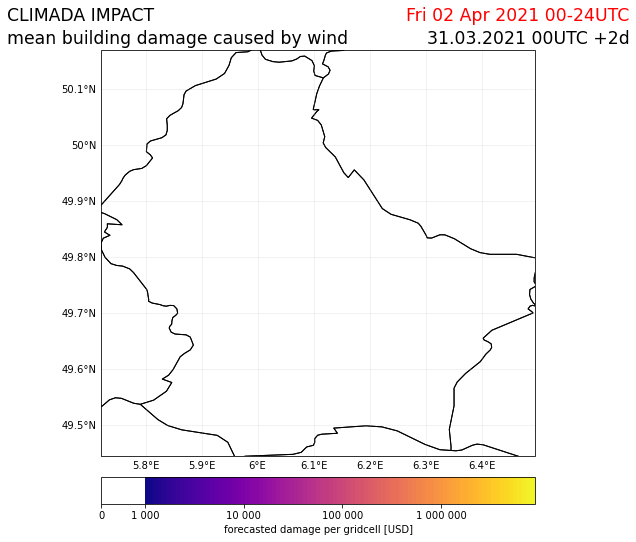

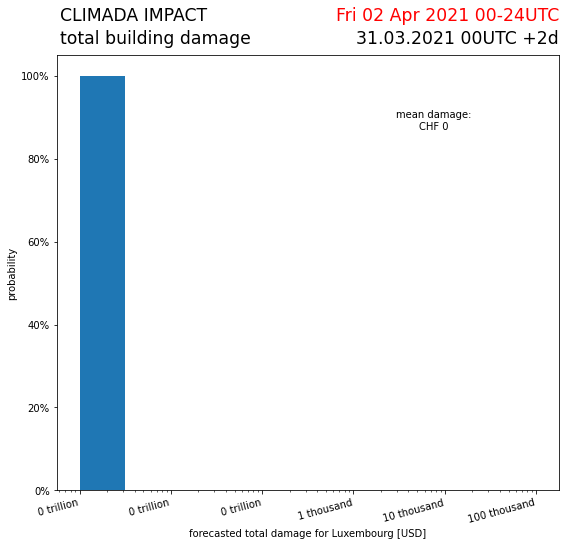

In [15]:
luxembourg_forecast.plot_imp_map(save_fig=False,close_fig=False)
luxembourg_forecast.plot_hist(save_fig=False,close_fig=False)